In [1]:
## first softmax version
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
## first softmax version
%load_ext autoreload
%autoreload 2
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Initial loss: 685932.1250
Epoch 0, Loss: 685932.1250
Epoch 10, Loss: 91249.4297
Epoch 20, Loss: 16900.9531
Epoch 30, Loss: 4464.5264
Epoch 40, Loss: -3118.6665
Epoch 50, Loss: -6450.7803
Epoch 60, Loss: -7576.8208
Epoch 70, Loss: -8109.0664
Epoch 80, Loss: -8392.8330
Epoch 90, Loss: -8640.2764


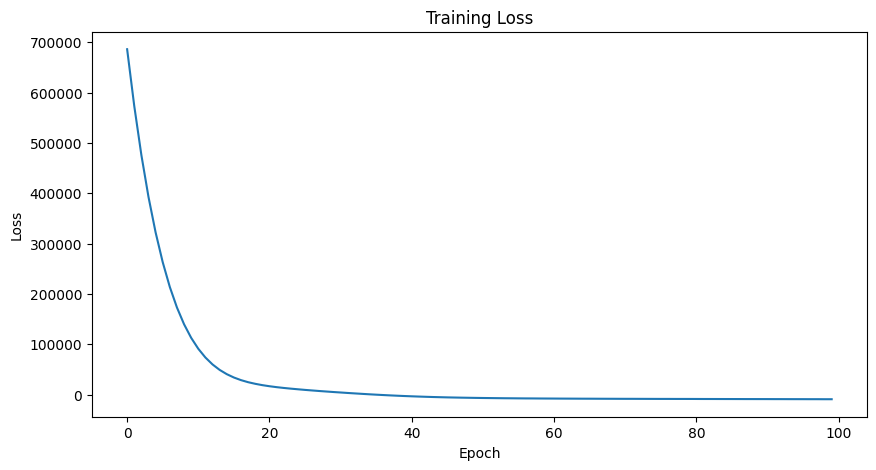

In [2]:
# Cell 1: Import the module
from gp_softmax_torch import *

# Cell 2: Generate synthetic data
N, D, T, K, P = 100, 5, 50, 3, 5  # Set dimensions
Y_np, G_np, prevalence_np, length_scales_np, amplitudes_np, event_times_np = generate_synthetic_data(
    N=N, D=D, T=T, K=K, P=P
)

# Cell 3: Initialize model
model = AladynSurvivalModel(
    N=N, D=D, T=T, K=K, P=P,
    G=G_np,
    length_scales=length_scales_np,
    amplitudes=amplitudes_np,
    prevalence=prevalence_np
)

# Cell 4: Convert data to PyTorch tensors
Y = torch.tensor(Y_np, dtype=torch.float32)
event_times = torch.tensor(event_times_np, dtype=torch.long)

# Cell 5: Setup optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Cell 6: Initial loss
loss = model.compute_loss(Y, event_times)
print(f"Initial loss: {loss.item():.4f}")

# Cell 7: Training loop
n_epochs = 100
losses = []
for epoch in range(n_epochs):
    optimizer.zero_grad()
    loss = model.compute_loss(Y, event_times)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Cell 8: Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

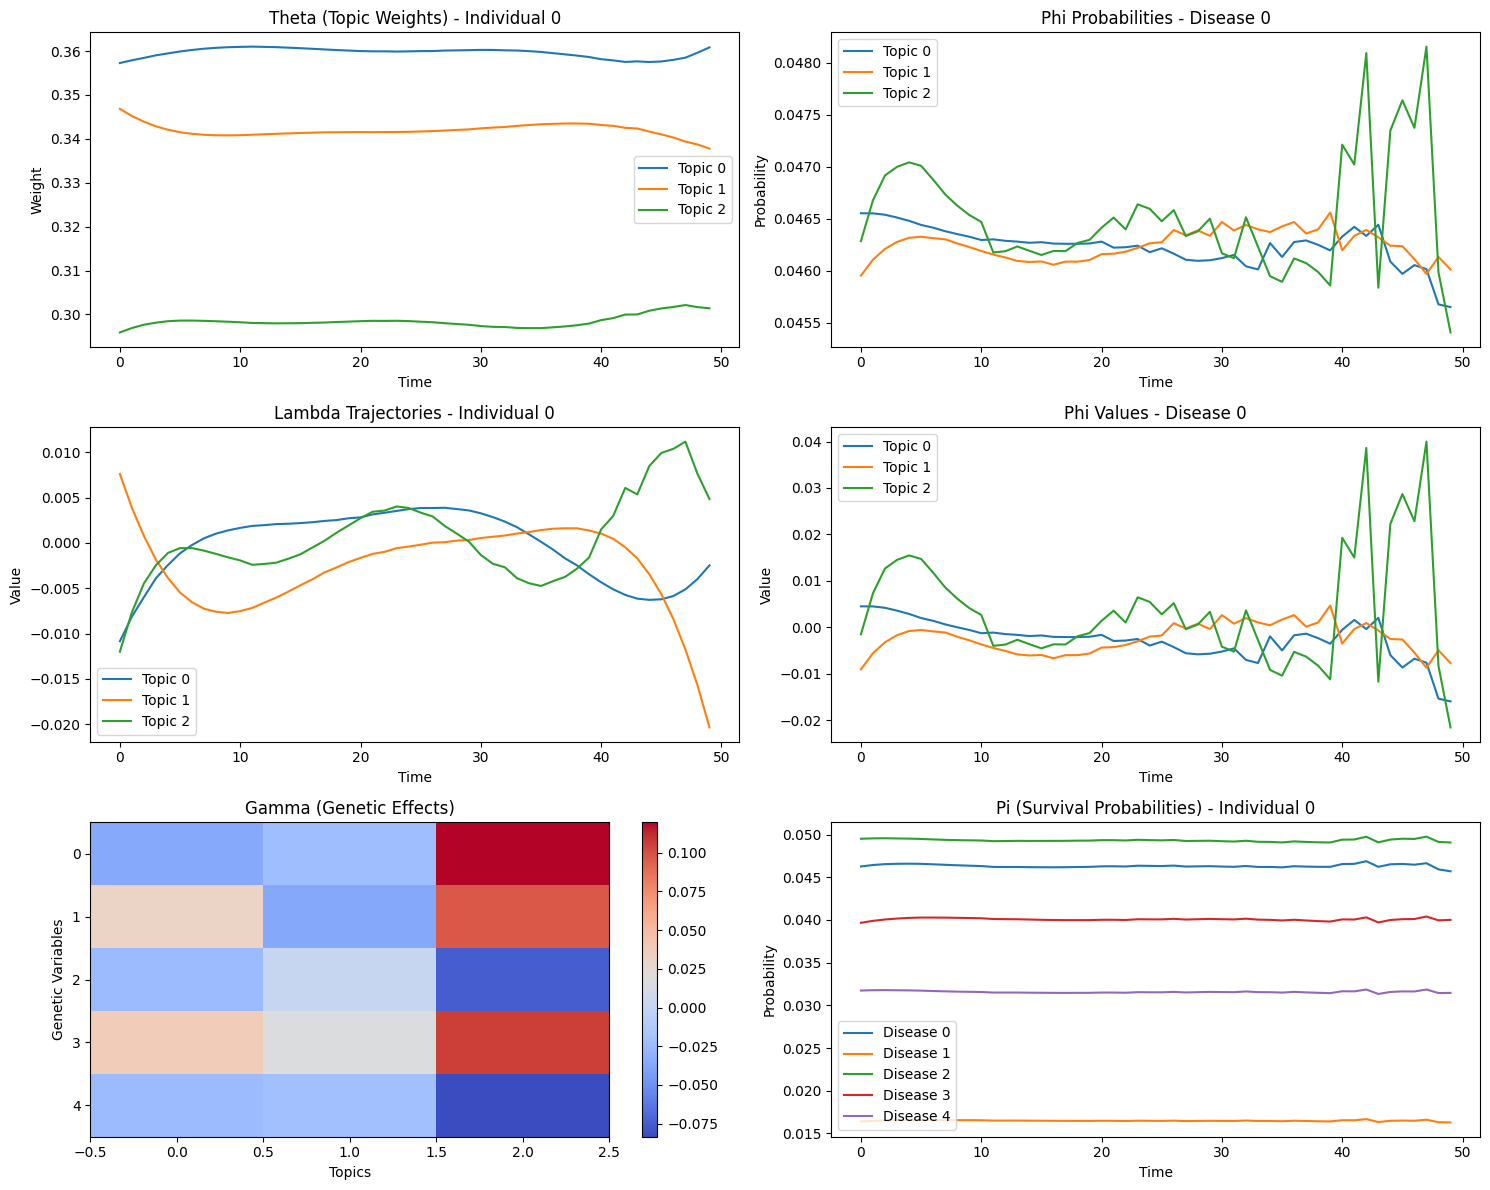

In [3]:
# Get model outputs
pi, theta, phi_prob = model.forward()

# Create visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Survival Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()

plt.tight_layout()
plt.show()

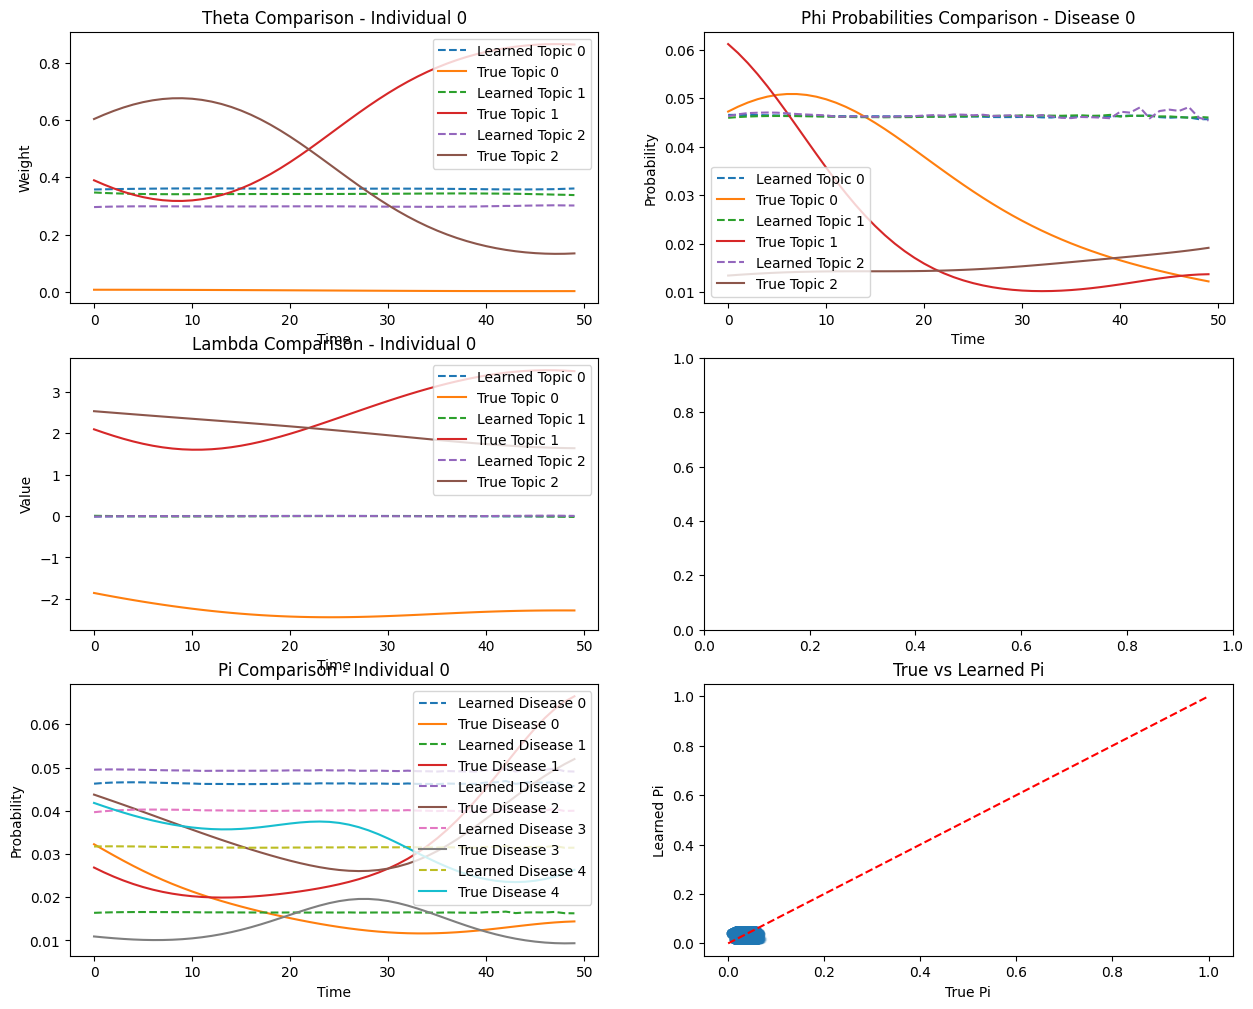

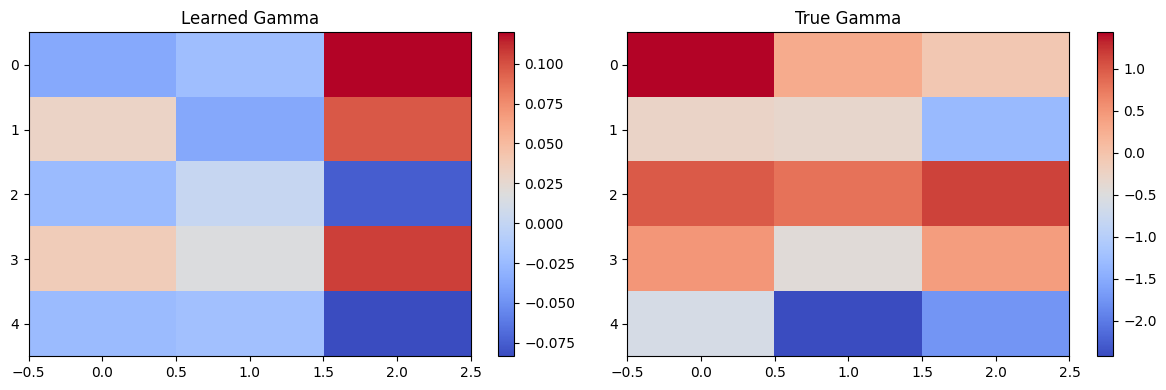

R² score for pi: -1.739
R² score for theta: -0.006


In [4]:
# First, generate synthetic data and save true values
N, D, T, K, P = 100, 5, 50, 3, 5
Y_np, G_np, prevalence_np, length_scales_np, amplitudes_np, event_times_np = generate_synthetic_data(
    N=N, D=D, T=T, K=K, P=P
)

# Get the true values from generating process
true_values = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)
true_theta = true_values['theta']
true_phi = true_values['phi']
true_lambda = true_values['lambda']
true_gamma = true_values['gamma']
true_pi = true_values['pi']

# Get learned values
pi, theta, phi_prob = model.forward()

# Create comparison plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Compare theta (topic weights)
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], '--', label=f'Learned Topic {k}')
    axes[0, 0].plot(true_theta[0, k, :], '-', label=f'True Topic {k}')
axes[0, 0].set_title('Theta Comparison - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Compare phi probabilities
phi_prob_np = phi_prob.detach().numpy()
true_phi_prob = expit(true_phi)
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], '--', label=f'Learned Topic {k}')
    axes[0, 1].plot(true_phi_prob[k, 0, :], '-', label=f'True Topic {k}')
axes[0, 1].set_title('Phi Probabilities Comparison - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Compare lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], '--', label=f'Learned Topic {k}')
    axes[1, 0].plot(true_lambda[0, k, :], '-', label=f'True Topic {k}')
axes[1, 0].set_title('Lambda Comparison - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Compare gamma (genetic effects)
gamma_np = model.gamma.detach().numpy()
fig_gamma = plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(gamma_np, aspect='auto', cmap='coolwarm')
plt.title('Learned Gamma')
plt.colorbar()
plt.subplot(122)
plt.imshow(true_gamma, aspect='auto', cmap='coolwarm')
plt.title('True Gamma')
plt.colorbar()

# 5. Compare survival probabilities
pi_np = pi.detach().numpy()
for d in range(D):
    axes[2, 0].plot(pi_np[0, d, :], '--', label=f'Learned Disease {d}')
    axes[2, 0].plot(true_pi[0, d, :], '-', label=f'True Disease {d}')
axes[2, 0].set_title('Pi Comparison - Individual 0')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Probability')
axes[2, 0].legend()

# 6. Plot correlation between true and learned parameters
axes[2, 1].scatter(true_pi.flatten(), pi_np.flatten(), alpha=0.1)
axes[2, 1].plot([0, 1], [0, 1], 'r--')
axes[2, 1].set_title('True vs Learned Pi')
axes[2, 1].set_xlabel('True Pi')
axes[2, 1].set_ylabel('Learned Pi')

plt.tight_layout()
plt.show()

# Print some numerical metrics
from sklearn.metrics import r2_score
print(f"R² score for pi: {r2_score(true_pi.flatten(), pi_np.flatten()):.3f}")
print(f"R² score for theta: {r2_score(true_theta.flatten(), theta_np.flatten()):.3f}")